In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from scipy.optimize import minimize
from scipy.stats import chi2
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 600)

### 1. simulate data

In [2]:
np.random.seed(96)

n_entities = 600
n_periods = 20  


period = np.tile(np.arange(n_periods), n_entities) 
entity = np.repeat(np.arange(n_entities), n_periods)

# covariates 
X1 = np.random.normal(0, 1, n_entities * n_periods)  
X2 = np.random.uniform(1, 2, n_entities * n_periods)

# treatment, assume treatment happening in the 16th period (period starts from 0 and so 16th period has period=15, randomly assigned
treatment = np.zeros(n_entities * n_periods)  
for i in range(n_entities-1):
    treatment[i*n_periods + 15] = np.random.binomial(1, 0.5, 1)
    for j in range(16,20):
        treatment[i*n_periods + j] = treatment[i*n_periods + 15]

# outcome, treatment effect decays from 0.69 in period 15 to 0.1379 in period 19, total periods are from 0 to 19, generate treatment effect for each period
treatment_effect = 0.69 * (1 - (period - 15) / 5)
Y = 3 + 1.6 * X1 + 0.9 * X2 + treatment_effect * treatment + np.random.normal(0, 1, n_entities * n_periods)

# print the treatment effect for each period from period 15 to 19
print(f'treatment effect for each period from period 15 to 19: {treatment_effect[15:20]}')

df = pd.DataFrame({'entity': entity, 'period': period, 'X1': X1, 'X2': X2, 'treatment': treatment, 'Y': Y})

print(df['treatment'].value_counts())

df


treatment effect for each period from period 15 to 19: [0.69  0.552 0.414 0.276 0.138]
treatment
0.0    10545
1.0     1455
Name: count, dtype: int64


C:\Users\tingb\AppData\Local\Temp\ipykernel_42272\1994085577.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  treatment[i*n_periods + 15] = np.random.binomial(1, 0.5, 1)


,entity,period,X1,X2,treatment,Y
0,0,0,0.069848,1.213157,0.0,5.183403
1,0,1,-0.048665,1.600688,0.0,2.248053
2,0,2,-0.659746,1.186885,0.0,5.055630
3,0,3,0.357369,1.309752,0.0,5.145882
4,0,4,0.132040,1.377749,0.0,3.008381
...,...,...,...,...,...,...
11995,599,15,0.434650,1.988461,0.0,5.674875
11996,599,16,-0.896533,1.673821,0.0,4.813758
11997,599,17,-0.345213,1.553148,0.0,3.715145
11998,599,18,1.069902,1.278833,0.0,4.874827


In [3]:
# check if the treatment is assigned correctly for each period from 15 to 19    
for period in range(15,20):
    print(df[df['period'] == period]['treatment'].value_counts())


treatment
0.0    309
1.0    291
Name: count, dtype: int64
treatment
0.0    309
1.0    291
Name: count, dtype: int64
treatment
0.0    309
1.0    291
Name: count, dtype: int64
treatment
0.0    309
1.0    291
Name: count, dtype: int64
treatment
0.0    309
1.0    291
Name: count, dtype: int64


### 2. propensity score matching

##### 2.1 predict propensity score based on pre-treatment covariates

In [4]:
pre_treatment_df = df[df['period'] < 15]
aggregated_pre_treatment_df = pre_treatment_df.groupby('entity').agg({
    'X1': 'mean',
    'X2': 'mean',
}).reset_index()
period15_treatment = df[df.period==15][['entity','treatment']]
aggregated_df = pd.merge(aggregated_pre_treatment_df, period15_treatment, on='entity',validate="1:1")
X = aggregated_df[['X1', 'X2']]
y = aggregated_df['treatment']

log_reg = LogisticRegression()
log_reg.fit(X, y)
aggregated_df['propensity_score'] = log_reg.predict_proba(X)[:, 1]

##### 2.2 check the overlap in the propensity score between treatment and control

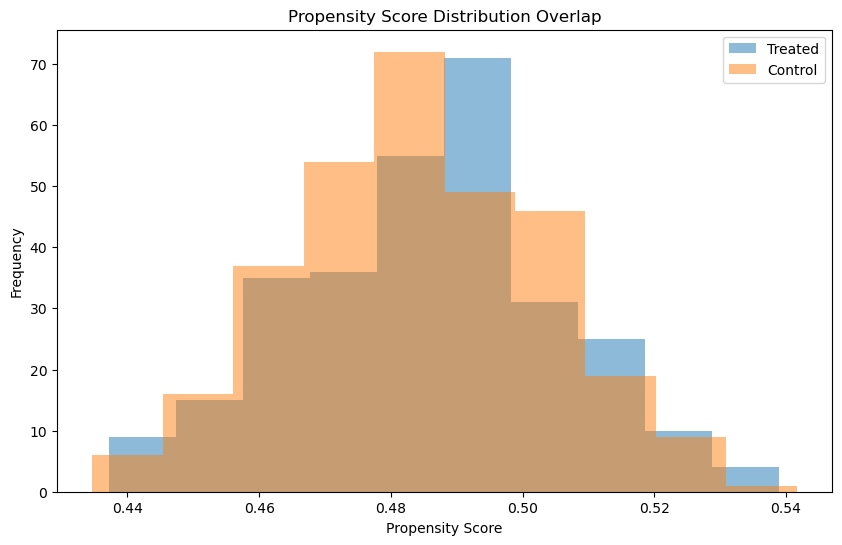

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(aggregated_df[aggregated_df['treatment'] == 1]['propensity_score'], alpha=0.5, label='Treated')
plt.hist(aggregated_df[aggregated_df['treatment'] == 0]['propensity_score'], alpha=0.5, label='Control')
plt.title('Propensity Score Distribution Overlap')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##### 2.3 match treatment and control based on propensity score, and check balance in covariates between treatment and matched control

(291, 5) (309, 5) (291, 5) (582, 5)


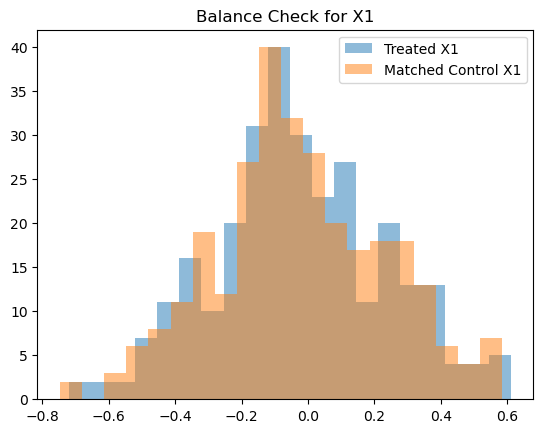

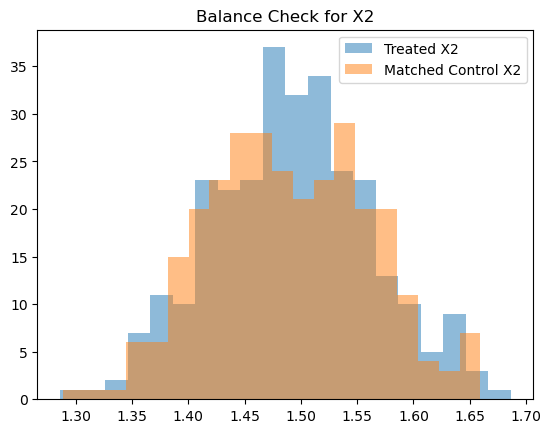

In [6]:
treated = aggregated_df[aggregated_df['treatment'] == 1]
control = aggregated_df[aggregated_df['treatment'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_controls = control.iloc[indices.flatten()]

matched_data = pd.concat([treated, matched_controls])

print(treated.shape, control.shape, matched_controls.shape, matched_data.shape)

# check balance in covariates between treatment and matched control
for covariate in ['X1', 'X2']:
    plt.hist(treated[covariate], alpha=0.5, label=f'Treated {covariate}', bins=20)
    plt.hist(matched_controls[covariate], alpha=0.5, label=f'Matched Control {covariate}', bins=20)
    plt.legend()
    plt.title(f'Balance Check for {covariate}')
    plt.show()


##### 2.4 estimate treatment effect for each period from 15 to 19

In [7]:
# Estimate treatment effect for each period from 15 to 19, recall from simulation that treatemnt effects are in 0.69  0.552 0.414 0.276 0.138]
for period in range(15,20):
    treated_outcomes = df[df['entity'].isin(treated['entity']) & (df['period'] == period)]['Y']
    matched_control_outcomes = df[df['entity'].isin(matched_controls['entity']) & (df['period'] == period)]['Y']
    treatment_effect = treated_outcomes.mean() - matched_control_outcomes.mean()
    print(f"Estimated Treatment Effect for period {period}: {treatment_effect}")


Estimated Treatment Effect for period 15: 0.6030519818683118
Estimated Treatment Effect for period 16: 0.48346338128476596
Estimated Treatment Effect for period 17: 0.44223848753155526
Estimated Treatment Effect for period 18: 0.573591779400263
Estimated Treatment Effect for period 19: -0.05257068323397185


##### 2.5 use bootstrapping to estimate standard error of ATE in each period from 15 to 19

In [8]:
n_bootstrap = 1000
ate_bootstrap = []

for _ in range(n_bootstrap):
    treated_sample = resample(treated)
    distances, indices = nn.kneighbors(treated_sample[['propensity_score']])
    matched_control_sample = control.iloc[indices.flatten()]
    
    ate_bootstrap_period = []
    for period in range(15,20):
        treated_outcomes = df[df['entity'].isin(treated_sample['entity']) & (df['period'] == period)]['Y']
        matched_control_outcomes = df[df['entity'].isin(matched_control_sample['entity']) & (df['period'] == period)]['Y']
        ate_bs = (treated_outcomes.mean() - matched_control_outcomes.mean())
        ate_bootstrap_period.append(ate_bs)
    ate_bootstrap.append(ate_bootstrap_period)

# ate_bootstrap is a list of lists, each list is the bootstrap results for each sample, each element in the list is the ATE for each period, 
# to get the bootstrap std of ATE for each period, we need to take std of first element in each list, second element in each list, etc.
ate_bootstrap_std = np.std(ate_bootstrap, axis=0)
print(f"Standard Error of ATE (propensity score matching) from period 15 to 19: {ate_bootstrap_std}")


Standard Error of ATE (propensity score matching) from period 15 to 19: [0.11487772 0.12000078 0.12488124 0.1100835  0.10726342]


##### 2.6 alternatively, to estimate ATE in period 15 to 19, we can run regression on matched sample based on propensity score

In [9]:
# alternatively, to estimate ATE in period 15 to 19, we can run regression on matched sample based on propensity score
treated_from_15_df = df[df['entity'].isin(treated['entity']) & (df['period'] >=15)]
matched_control_from_15_df = df[df['entity'].isin(matched_controls['entity']) & (df['period'] >=15)]
matched_from_15_df = pd.concat([treated_from_15_df, matched_control_from_15_df])
# to estimate ATE in period 15 to 19, we need to have the treatment coefficient for each period from 15 to 19, treatment interaction with period from 15 to 19, 
# generate period dummy variable for each period from 15 to 19 as one column in matched_from_15_df
period_dummy = pd.get_dummies(matched_from_15_df['period'], prefix='period')
period_dummy = period_dummy[['period_15', 'period_16', 'period_17', 'period_18', 'period_19']]
matched_from_15_df = pd.concat([matched_from_15_df, period_dummy], axis=1)    

model_psm = smf.ols('Y ~ 1 + treatment  + treatment*period_16 + treatment*period_17 + treatment*period_18 + treatment*period_19', data=matched_from_15_df).fit()
model_psm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.457
Date:                Wed, 01 Jan 2025   Prob (F-statistic):           8.19e-06
Time:                        20:58:14   Log-Likelihood:                -4703.7
No. Observations:                2275   AIC:                             9427.
Df Residuals:                    2265   BIC:                             9485.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.4109      0.150     29.465      0.000       4.117       4.704
period_16[T.True]               0.0078      0.212      0.037      0.970      -0.407       0.423
period_17[T.True]              -0.1445      0.212     -0.683      0.495      -0.560       0.271
period_18[T.True]              -0.1613      0.212     -0.762      0.446      -0.576       0.254
period_19[T.True]               0.1085      0.212      0.513      0.608      -0.307       0.524
treatment                       0.6031      0.187      3.222      0.001       0.236       0.970
treatment:period_16[T.True]    -0.1196      0.265     -0.452      0.651      -0.639       0.400
treatment:period_17[T.True]    -0.1608      0.265     -0.607      0.544      -0.680       0.358
treatment:period_18[T.True]    -0.0295      0.265     -0.111      0.911      -0.549       0.490
treatment:period_19[T.True]    -0.6556      0.265     -2.477      0.013      -1.175      -0.136
==============================================================================
Omnibus:                        3.633   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.942
Skew:                          -0.027   Prob(JB):                        0.139
Kurtosis:                       3.197   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# print the treatment coefficient for each period from 15 to 19, one line for each period
print(f"Treatment coefficient for period 15: {model_psm.params['treatment']} ")
# for each period from 16 to 19, print the treatment effect = treatment coefficient for that period + treatment coefficient for period 15
for period in range(16,20):
    print(f"Treatment effect for period {period}: {model_psm.params['treatment'] + model_psm.params[f'treatment:period_{period}[T.True]']}")


Treatment coefficient for period 15: 0.603051981868288 
Treatment effect for period 16: 0.4834633812847424
Treatment effect for period 17: 0.44223848753153355
Treatment effect for period 18: 0.5735917794002416
Treatment effect for period 19: -0.052570683233994386


##### 2.7 inverse propensity score weighting

In [11]:
# ATE using inverse propensity score weighting for each period from 15 to 19 
# merge propensity score with df
df = pd.merge(df, aggregated_df[['entity','propensity_score']], on='entity', how='left', validate="m:1")
df['weight'] = np.where(df['treatment'] == 1, 1 / df['propensity_score'], 1 / (1 - df['propensity_score']))
for period in range(15,20):
    period_df = df[df['period'] == period]
    treated_y_weighted_mean = (period_df[period_df['treatment'] == 1]['Y'] * period_df[period_df['treatment'] == 1]['weight']).sum() / period_df[period_df['treatment'] == 1]['weight'].sum()
    control_y_weighted_mean = (period_df[period_df['treatment'] == 0]['Y'] * period_df[period_df['treatment'] == 0]['weight']).sum() / period_df[period_df['treatment'] == 0]['weight'].sum()
    ATE = treated_y_weighted_mean - control_y_weighted_mean
    print(f"Average Treatment Effect (ATE) using inverse propensity score weighting for period {period}: {ATE}")

Average Treatment Effect (ATE) using inverse propensity score weighting for period 15: 0.5953189348339425
Average Treatment Effect (ATE) using inverse propensity score weighting for period 16: 0.590921243977645
Average Treatment Effect (ATE) using inverse propensity score weighting for period 17: 0.37107248325543196
Average Treatment Effect (ATE) using inverse propensity score weighting for period 18: 0.3605765904496847
Average Treatment Effect (ATE) using inverse propensity score weighting for period 19: 0.07467668573133501


In [12]:
from_15_df = df[df['period'] >= 15]
# generate period dummy variable for each period from 15 to 19 as one column in from_15_df
period_dummy = pd.get_dummies(from_15_df['period'], prefix='period')
period_dummy = period_dummy[['period_15', 'period_16', 'period_17', 'period_18', 'period_19']]
from_15_df = pd.concat([from_15_df, period_dummy], axis=1)    

model_ipw = smf.wls(
    'Y ~ 1 + treatment  + treatment*period_16 + treatment*period_17 + treatment*period_18 + treatment*period_19',
    data=from_15_df,
    weights=from_15_df['weight']
).fit()
model_ipw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.259
Date:                Wed, 01 Jan 2025   Prob (F-statistic):           3.91e-07
Time:                        20:58:14   Log-Likelihood:                -6202.2
No. Observations:                3000   AIC:                         1.242e+04
Df Residuals:                    2990   BIC:                         1.248e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.4167      0.111     39.953      0.000       4.200       4.633
period_16[T.True]              -0.1071      0.156     -0.685      0.493      -0.414       0.199
period_17[T.True]              -0.0762      0.156     -0.487      0.626      -0.383       0.230
period_18[T.True]               0.0445      0.156      0.285      0.776      -0.262       0.351
period_19[T.True]              -0.0143      0.156     -0.092      0.927      -0.321       0.292
treatment                       0.5953      0.156      3.808      0.000       0.289       0.902
treatment:period_16[T.True]    -0.0044      0.221     -0.020      0.984      -0.438       0.429
treatment:period_17[T.True]    -0.2242      0.221     -1.014      0.311      -0.658       0.209
treatment:period_18[T.True]    -0.2347      0.221     -1.062      0.288      -0.668       0.199
treatment:period_19[T.True]    -0.5206      0.221     -2.355      0.019      -0.954      -0.087
==============================================================================
Omnibus:                        4.682   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                5.288
Skew:                          -0.001   Prob(JB):                       0.0711
Kurtosis:                       3.206   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
print(f"Treatment coefficient for period 15: {model_ipw.params['treatment']} ")
for period in range(16,20):
    print(f"Treatment effect for period {period}: {model_ipw.params['treatment'] + model_ipw.params[f'treatment:period_{period}[T.True]']}")


Treatment coefficient for period 15: 0.5953189348339427 
Treatment effect for period 16: 0.5909212439776458
Treatment effect for period 17: 0.3710724832554324
Treatment effect for period 18: 0.36057659044968576
Treatment effect for period 19: 0.07467668573133568


### 3. diff-in-diff

In [14]:
# within each entity, replace treatment with 1 for period 0 to period 14 if it is 1 for period 15, using backfill
df.loc[(df['period']<15), 'treatment'] = np.nan
df['treatment'] = df.groupby('entity')['treatment'].bfill()
print(df.head(60))

    entity  period        X1        X2  treatment          Y  propensity_score    weight
0        0       0  0.069848  1.213157        0.0   5.183403          0.519252  2.080093
1        0       1 -0.048665  1.600688        0.0   2.248053          0.519252  2.080093
2        0       2 -0.659746  1.186885        0.0   5.055630          0.519252  2.080093
3        0       3  0.357369  1.309752        0.0   5.145882          0.519252  2.080093
4        0       4  0.132040  1.377749        0.0   3.008381          0.519252  2.080093
5        0       5 -0.868419  1.908317        0.0   3.464862          0.519252  2.080093
6        0       6 -0.520153  1.868638        0.0   3.786472          0.519252  2.080093
7        0       7  0.080568  1.566530        0.0   1.941478          0.519252  2.080093
8        0       8 -1.202208  1.220509        0.0   1.249126          0.519252  2.080093
9        0       9 -0.996865  1.287080        0.0   1.958563          0.519252  2.080093
10       0      10 -1

##### 3.1 check if parallel trend holds for the full sample: graph and regression

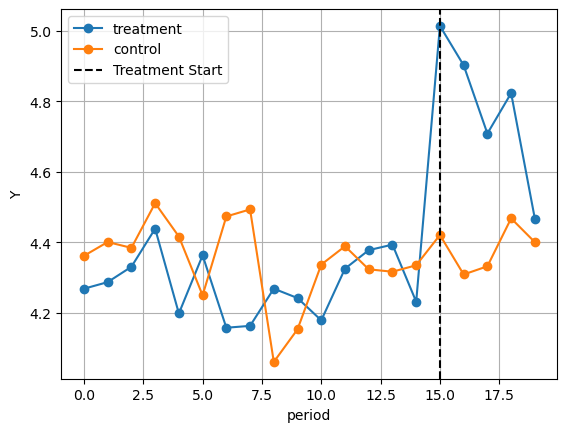

In [15]:
df[df['treatment']==1].groupby('period')['Y'].mean().plot(label='treatment',marker='o')
df[df['treatment']==0].groupby('period')['Y'].mean().plot(label='control',marker='o')
plt.xlabel('period')
plt.ylabel('Y')
plt.legend()
plt.axvline(x=15, color='black', linestyle='--', label='Treatment Start')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Create period dummies for pre-treatment periods
pre_treatment_df = df[df['period'] < 15]
period_dummies = pd.get_dummies(pre_treatment_df['period'], prefix='period')
period_dummies = period_dummies.drop('period_0', axis=1)

X = pd.DataFrame({
        'treatment': pre_treatment_df['treatment']  # treatment dummy
    })
    
X = pd.concat([X, period_dummies], axis=1)

# Interact period dummies with treatment
for col in period_dummies.columns:
    X[f'{col}_x_treat'] = period_dummies[col] * pre_treatment_df['treatment']

X = sm.add_constant(X)
X = X.astype(float)
model = sm.OLS(pre_treatment_df['Y'], X).fit()
print(model.summary())
print(model.params)

# Extract interaction coefficients and covariance matrix
interaction_coeffs = model.params.filter(like='treatment:C(period)')
cov_matrix = model.cov_params().loc[interaction_coeffs.index, interaction_coeffs.index]

# Chi-square statistic
chi2_stat = interaction_coeffs.T @ np.linalg.inv(cov_matrix) @ interaction_coeffs
p_value = chi2.sf(chi2_stat, df=len(interaction_coeffs))

if p_value < 0.05:
    print("Reject the null hypothesis: Parallel trends assumption is violated.")
else:
    print("Fail to reject the null hypothesis: Parallel trends assumption holds.")

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.007
Date:                Wed, 01 Jan 2025   Prob (F-statistic):              0.455
Time:                        20:58:15   Log-Likelihood:                -18516.
No. Observations:                9000   AIC:                         3.709e+04
Df Residuals:                    8970   BIC:                         3.731e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.3616      0.10

##### 3.2 run diff-in-diff on the full sample

In [17]:
post_period_dummies = pd.get_dummies(df[df.period>=15]['period'], prefix='period').astype(float)
df = pd.concat([df, post_period_dummies], axis=1)
model_did_full = smf.ols('Y ~ 1 + treatment + period_15 + period_16 + period_17 + period_18 + period_19\
                              + treatment*period_15 + treatment*period_16 + treatment*period_17 + \
                              treatment*period_18 + treatment*period_19 + X1 + X2', 
                     data=df).fit()
print(model_did_full.summary())



                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     741.0
Date:                Wed, 01 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:58:15   Log-Likelihood:                -4250.7
No. Observations:                3000   AIC:                             8525.
Df Residuals:                    2988   BIC:                             8597.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.4632    

In [18]:
for period in range(15,20):
    print(f"Treatment effect for period {period}: {model_did_full.params['treatment'] + model_did_full.params[f'treatment:period_{period}']}")

Treatment effect for period 15: 0.5994522319791908
Treatment effect for period 16: 0.5798346330617559
Treatment effect for period 17: 0.3014990792422662
Treatment effect for period 18: 0.17242301612019795
Treatment effect for period 19: 0.1396779736034172


##### 3.3 check if parallel trend holds for the matched sample based on above propensity score matching

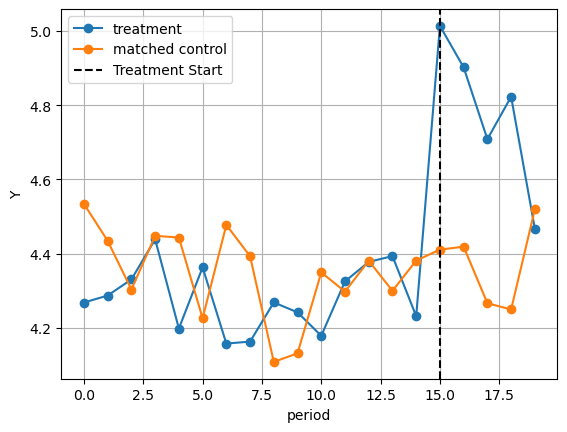

In [19]:
matched_df = df[df['entity'].isin(matched_data['entity'])]
matched_df[matched_df['treatment']==1].groupby('period')['Y'].mean().plot(label='treatment',marker='o')
matched_df[matched_df['treatment']==0].groupby('period')['Y'].mean().plot(label='matched control',marker='o')
plt.xlabel('period')
plt.ylabel('Y')
plt.legend()
plt.axvline(x=15, color='black', linestyle='--', label='Treatment Start')
plt.legend()
plt.grid(True)
plt.show()

##### 3.4 run diff-in-diff on the matched sample

In [20]:
model_did_matched = smf.ols('Y ~ 1 + treatment + period_15 + period_16 + period_17 + period_18 + period_19\
                              + treatment*period_15 + treatment*period_16 + treatment*period_17 + \
                              treatment*period_18 + treatment*period_19', 
                     data=matched_df).fit()
print(model_did_matched.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.457
Date:                Wed, 01 Jan 2025   Prob (F-statistic):           8.19e-06
Time:                        20:58:16   Log-Likelihood:                -4703.7
No. Observations:                2275   AIC:                             9427.
Df Residuals:                    2265   BIC:                             9485.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.6442    

In [21]:
for period in range(15,20):
    print(f"Treatment effect for period {period}: {model_did_matched.params['treatment'] + model_did_matched.params[f'treatment:period_{period}']}")

Treatment effect for period 15: 0.6030519818683123
Treatment effect for period 16: 0.48346338128476196
Treatment effect for period 17: 0.4422384875315546
Treatment effect for period 18: 0.5735917794002606
Treatment effect for period 19: -0.05257068323397118


### 4. synthetic control

##### 4.1 aggregate synthetic control by period

Synthetic control weight: 1.0


C:\Users\tingb\AppData\Local\Temp\ipykernel_42272\16657118.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_outcome = df[df['treatment'] == 0][df['period'] == period]['Y'].mean()
C:\Users\tingb\AppData\Local\Temp\ipykernel_42272\16657118.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actual_outcome = df[df['treatment'] == 1][df['period'] == period]['Y'].mean()
C:\Users\tingb\AppData\Local\Temp\ipykernel_42272\16657118.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_outcome = df[df['treatment'] == 0][df['period'] == period]['Y'].mean()
C:\Users\tingb\AppData\Local\Temp\ipykernel_42272\16657118.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actual_outcome = df[df['treatment'] == 1][df['period'] == period]['Y'].mean()
C:\Users\tingb\AppData\Local\Temp\ipykernel_42272\16657118.py:50: UserWarning: Boolean Series key will be rein

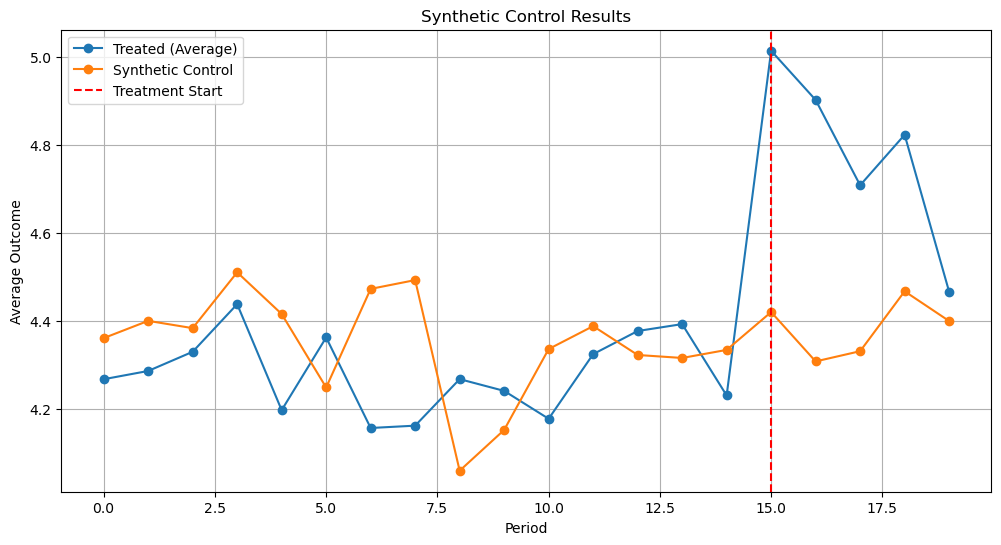


Treatment Effects:
Period 15: 0.5932
Period 16: 0.5935
Period 17: 0.3767
Period 18: 0.3553
Period 19: 0.0665

Predictor Balance (Pre-treatment means):
Variable   Treated   Synthetic   Difference
-----------------------------------------
Y          -0.6577    0.3411     -0.9988
X1         -0.0666    0.4481     -0.5147
X2          0.1147    0.4211     -0.3064


In [22]:
pre_treatment_df = df[df['period'] < 15]

def get_predictors_by_period(data, is_treated):
    return data[data['treatment'] == is_treated].groupby('period').agg({
        'Y': 'mean',
        'X1': 'mean',
        'X2': 'mean'
    })

treated_means = get_predictors_by_period(pre_treatment_df, is_treated=1)
control_means = get_predictors_by_period(pre_treatment_df, is_treated=0)

# Prepare matrices for optimization
X0_raw = control_means.values  
X1_raw = treated_means.values  
# Standardization (z-score) using all pre-treatment data
all_data = np.vstack([X0_raw, X1_raw])
mean = np.mean(all_data, axis=0)
std = np.std(all_data, axis=0)
# Apply same standardization to both X0 and X1
X0 = (X0_raw - mean) / std
X1 = (X1_raw - mean) / std

# V matrix (more weights on outcome than covariates)
V = np.diag([0.5, 0.25, 0.25])
# Function to minimize for finding W weights
def objective(w):
    return np.sum((X1 - w*X0) @ V @ (X1 - w*X0).T)

# weight constraint 
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # weight sums to 1
]
bounds = [(0, 1)]  # single weight between 0 and 1

# Optimize to find weight
#W_initial = [0.5]  
W_initial = [0.1]
result = minimize(objective, W_initial, 
                 constraints=constraints,
                 bounds=bounds,
                 method='SLSQP')
W = result.x[0]
print(f"Synthetic control weight: {W}")

# Calculate synthetic control outcomes for all periods
synthetic_outcomes = []
actual_outcomes = []
for period in range(20):
    control_outcome = df[df['treatment'] == 0][df['period'] == period]['Y'].mean()
    synthetic_outcomes.append(W * control_outcome)
    
    actual_outcome = df[df['treatment'] == 1][df['period'] == period]['Y'].mean()
    actual_outcomes.append(actual_outcome)

# Calculate treatment effects
treatment_effects = np.array(actual_outcomes) - np.array(synthetic_outcomes)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(20), actual_outcomes, label='Treated (Average)', marker='o')
plt.plot(range(20), synthetic_outcomes, label='Synthetic Control', marker='o')
plt.axvline(x=15, color='red', linestyle='--', label='Treatment Start')
plt.xlabel('Period')
plt.ylabel('Average Outcome')
plt.legend()
plt.grid(True)
plt.title('Synthetic Control Results')
plt.show()

# Print treatment effects for periods 15-19
print("\nTreatment Effects:")
for period, effect in zip(range(15, 20), treatment_effects[15:]):
    print(f"Period {period}: {effect:.4f}")

# Print predictor balance
print("\nPredictor Balance (Pre-treatment means):")
print("Variable   Treated   Synthetic   Difference")
print("-----------------------------------------")
for i, var in enumerate(['Y', 'X1', 'X2']):
    treated_mean = X1[i].mean()
    synthetic_mean = X0[i].mean() * W
    diff = treated_mean - synthetic_mean
    print(f"{var:8} {treated_mean:9.4f} {synthetic_mean:9.4f} {diff:11.4f}")
